In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, BatchNormalization
from tensorflow.keras.models import Model

In [3]:
CONFIGURATIONS = {
    'BATCH_SIZE':32,
    'IM_SIZE': 256,
    'LEARNING_RATE': 0.001,
    'N_EPOCH': 30,
    'N_DENSE_1': 1024,
    'N_DENSE_2': 128,
    'NUM_CLASSES':3
}

In [4]:
VGGNET = tf.keras.applications.vgg16.VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(CONFIGURATIONS['IM_SIZE'], CONFIGURATIONS['IM_SIZE'],3)
)

58889256/58889256 [==============================] - 1s 0us/step


In [5]:
 # filtering only convolutional layers
def is_conv(layer_name):
  if 'conv' in layer_name:
    return True
  else:
    return False

In [6]:
feature_maps = [layer.output for layer in VGGNET.layers[1:] if is_conv(layer.name)]

feature_map_model = Model(
    inputs = VGGNET.input,
    outputs = feature_maps
)

In [7]:
import cv2

In [9]:
test_image = cv2.imread('/content/drive/MyDrive/Human-Emotion-Detection/Emotions Dataset/test/happy/907911.jpg')
test_image = cv2.resize(test_image, (CONFIGURATIONS['IM_SIZE'],CONFIGURATIONS['IM_SIZE']))

im = tf.constant(test_image, dtype=tf.float32)
im = tf.expand_dims(im, axis=0)

In [10]:
f_maps = feature_map_model.predict(im)

1/1 [==============================] - 1s 1s/step


In [11]:
len(f_maps) # 13 convolutional layers

13

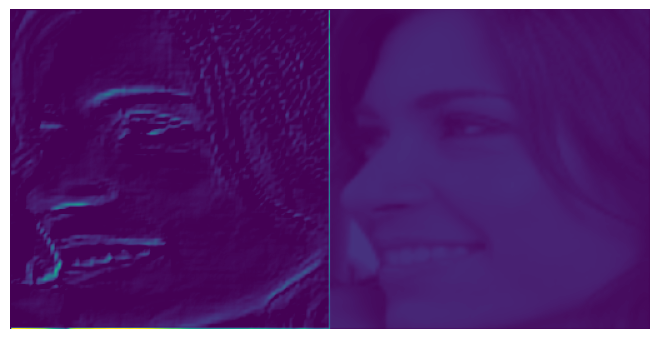

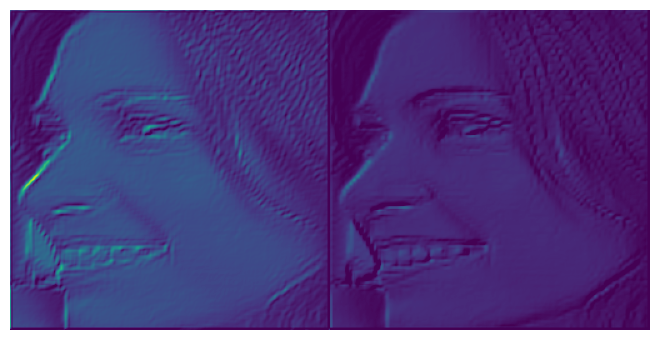

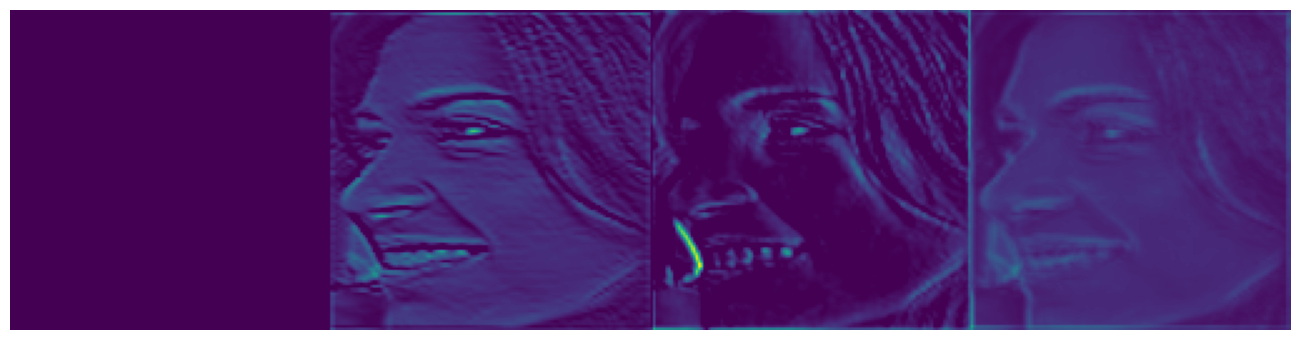

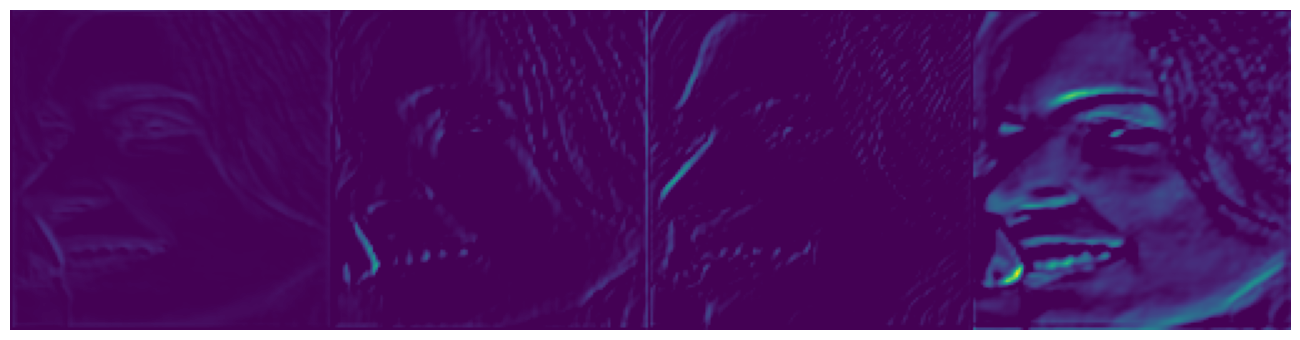

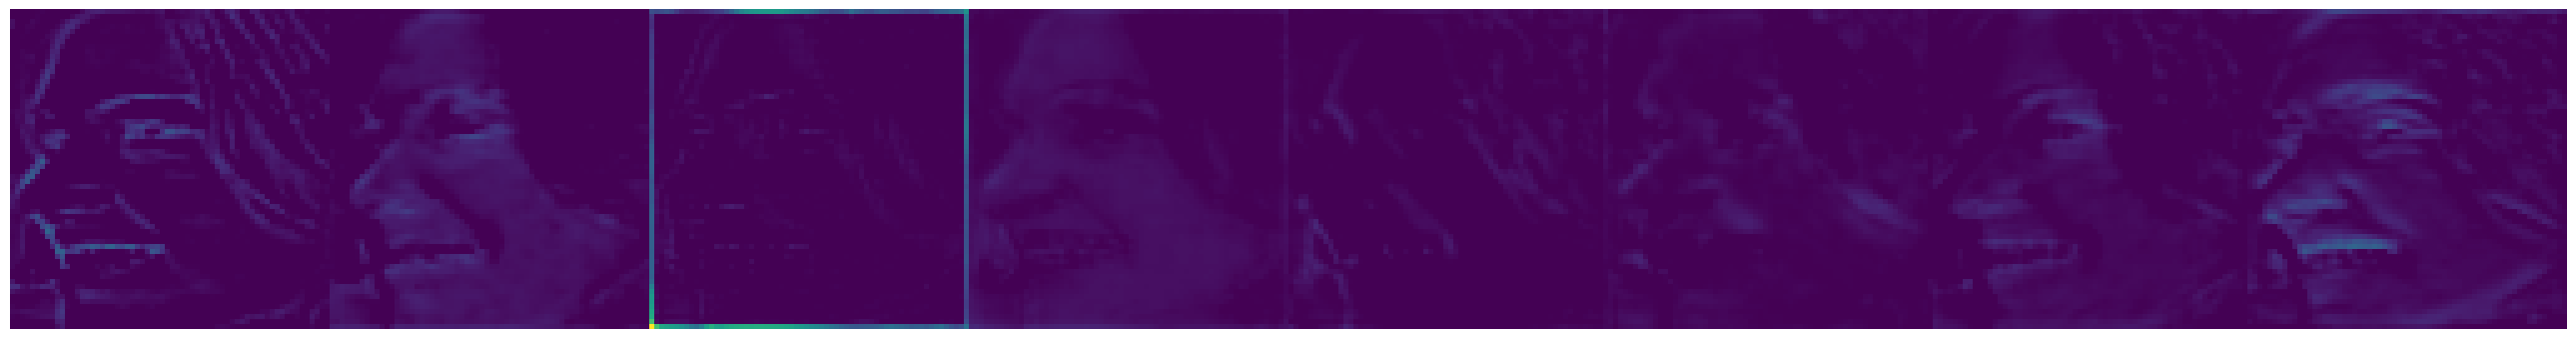

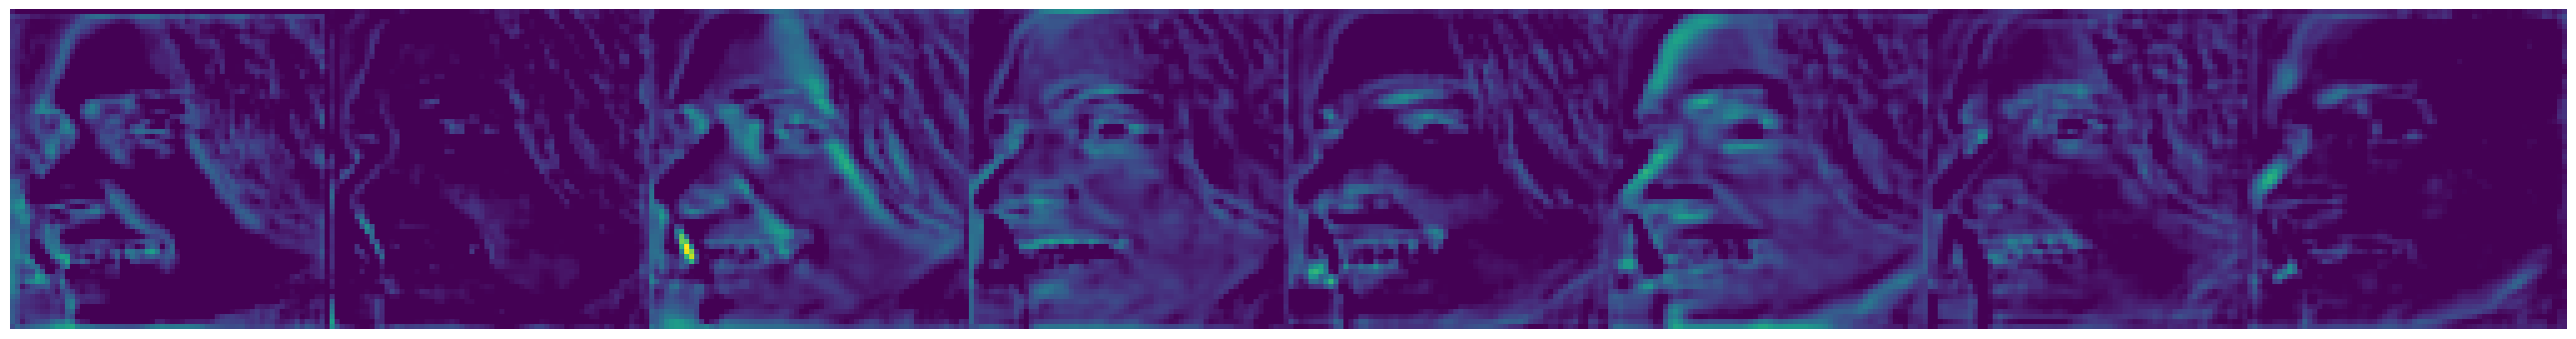

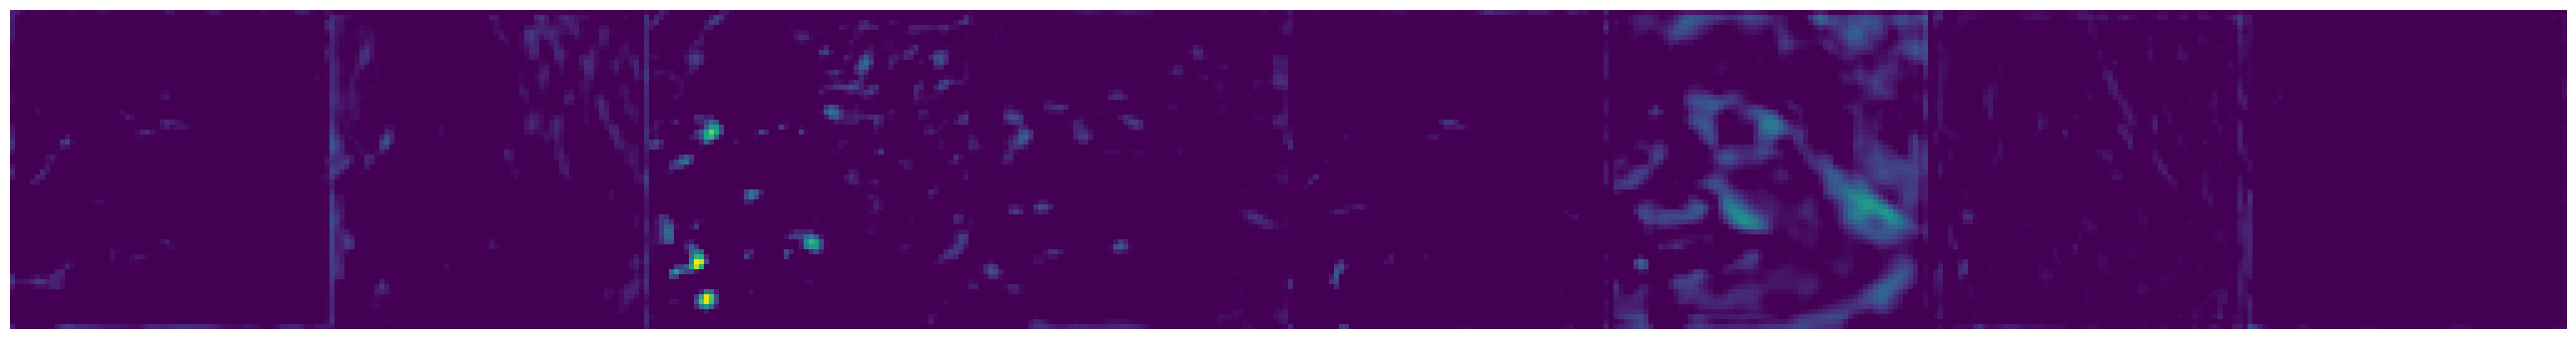

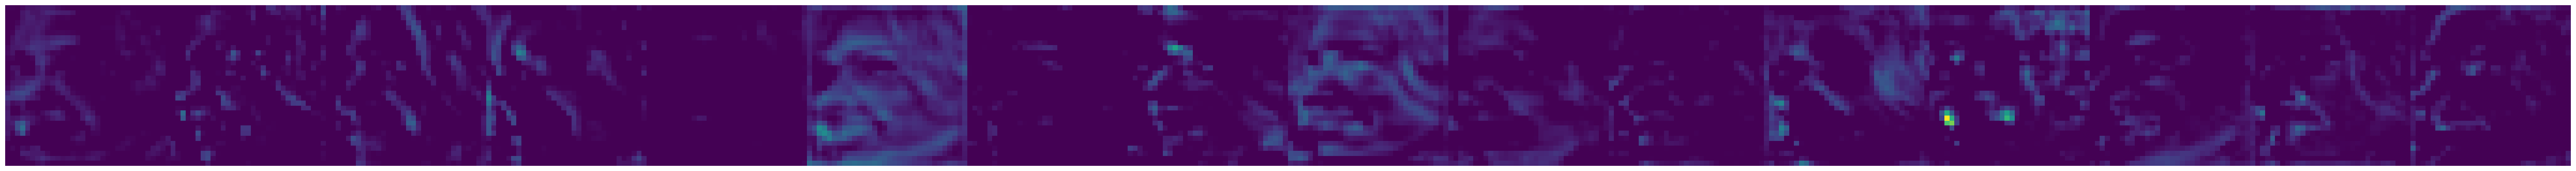

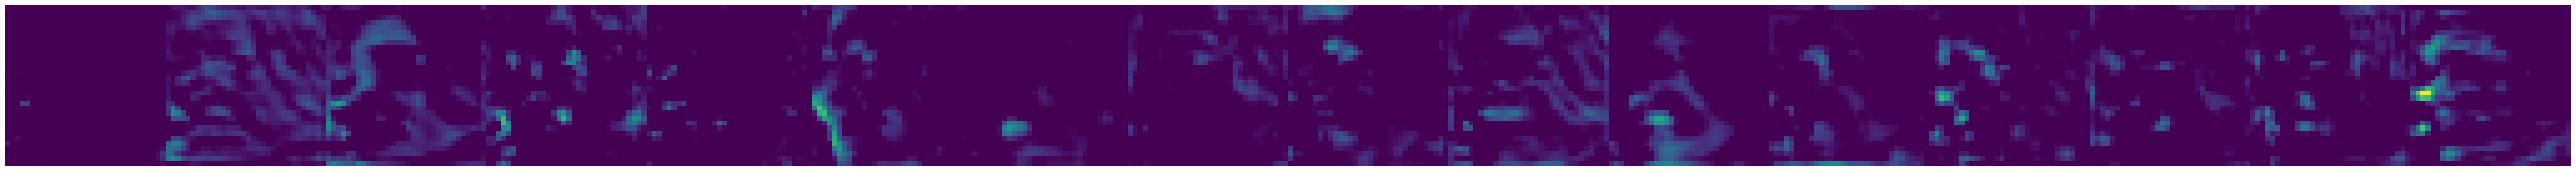

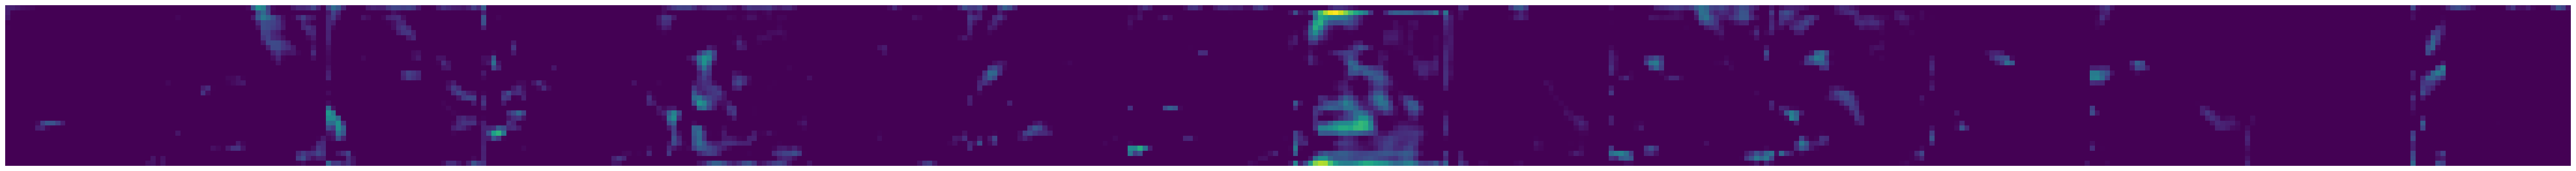

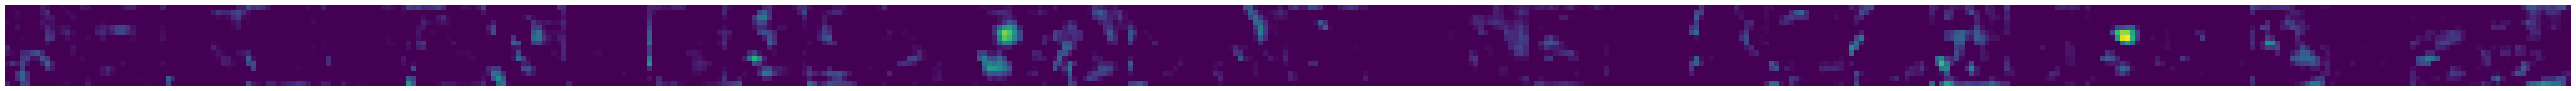

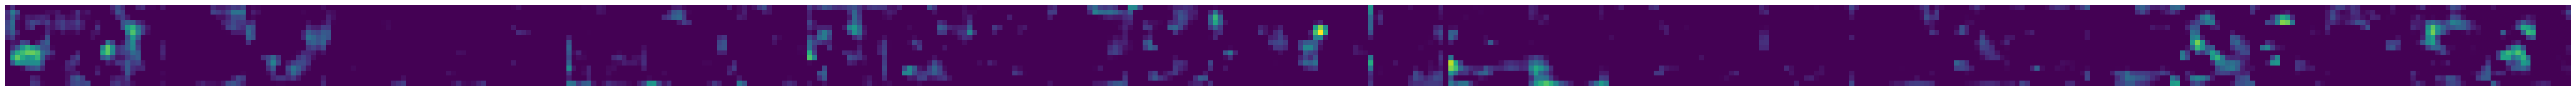

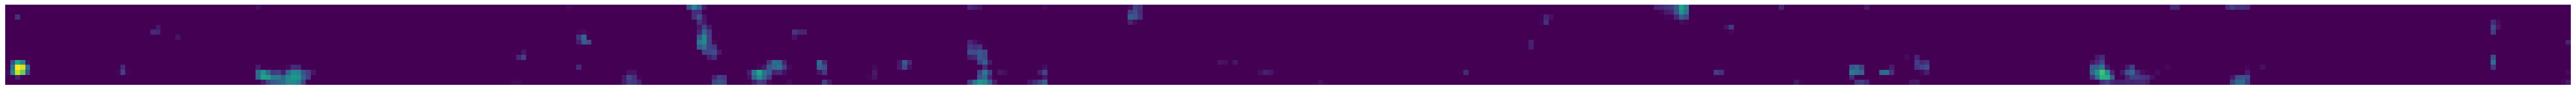

In [12]:
import numpy as np
import matplotlib.pyplot as plt

for i in range(0, len(f_maps)):
  plt.figure(figsize =(64, 64))
  f_size = f_maps[i].shape[1]
  n_channels = f_maps[i].shape[3]
  joint_maps = np.ones((f_size, f_size * n_channels))

  axs = plt.subplot(len(f_maps), 1, i+1)

  for j in range(n_channels):
    joint_maps[:, f_size*j:f_size*(j+1)] = f_maps[i][..., j]

  plt.imshow(joint_maps[:, 0:512])
  plt.axis('off')

### Using GradCam

In [13]:
EfficeintNetB4 = tf.keras.applications.efficientnet.EfficientNetB4(
    include_top=False,
    weights='imagenet',
    input_shape=(CONFIGURATIONS['IM_SIZE'], CONFIGURATIONS['IM_SIZE'],3)
)

71686520/71686520 [==============================] - 0s 0us/step


In [14]:
EfficeintNetB4.trainable = False

In [18]:
from tensorflow.keras.models import load_model
pretrained_efficientnet = load_model('/content/drive/MyDrive/Human-Emotion-Detection/EfficientNetB4/EfficientNetB4_Model_seq.keras')

In [22]:
test_image = cv2.imread('/content/drive/MyDrive/Human-Emotion-Detection/Emotions Dataset/test/happy/907911.jpg')
test_image = cv2.resize(test_image, (CONFIGURATIONS['IM_SIZE'],CONFIGURATIONS['IM_SIZE']))

im = tf.constant(test_image, dtype=tf.float32)
im = tf.expand_dims(im, axis=0)

preds = pretrained_efficientnet.predict(im)

1/1 [==============================] - 5s 5s/step


In [24]:
np.argmax(preds) # it is indeed a happy image

1

In [74]:
last_conv_layer_model = tf.keras.Model(EfficeintNetB4.input, EfficeintNetB4.output)

In [77]:
classifier_layers = [
    'global_average_pooling2d',
    'dense',
    'batch_normalization',
    'dense_1',
    'dense_2'
]

In [79]:
classifier_inputs = Input(shape=(8,8,1792))
x = classifier_inputs
for layer in classifier_layers:
  x = pretrained_efficientnet.get_layer(layer)(x)

classifier_model = Model(classifier_inputs, x)

In [80]:
with tf.GradientTape() as tape:
  last_conv_layer_output = last_conv_layer_model(im)
  preds = classifier_model(last_conv_layer_output)
  top_pred_idx = tf.argmax(preds[0])
  top_class_channel = preds[:, top_pred_idx]

grads = tape.gradient(top_class_channel, last_conv_layer_output)

In [83]:
pooled_grads = tf.reduce_mean(grads, axis =(0,1,2)).numpy()

In [85]:
last_conv_layer_output = last_conv_layer_output.numpy()[0]
for i in range(len(pooled_grads)):
  last_conv_layer_output[:,:,i]*=pooled_grads[i]

In [86]:
heatmap = np.sum(last_conv_layer_output, axis =-1)

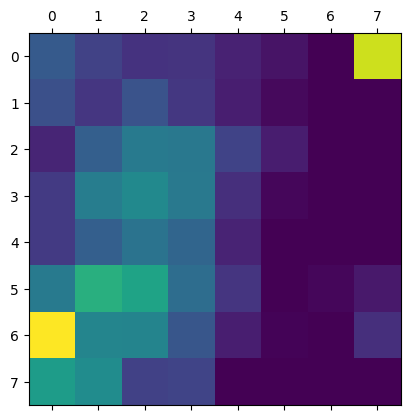

In [87]:
heatmap = tf.nn.relu(heatmap)
plt.matshow(heatmap)

(-0.5, 255.5, 255.5, -0.5)

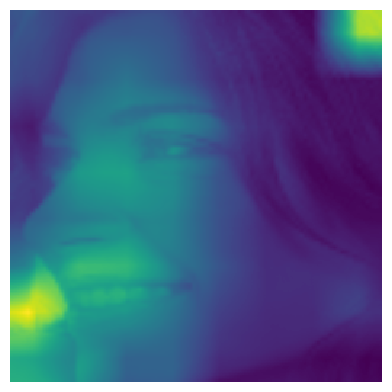

In [90]:
resized_heatmap = cv2.resize(np.array(heatmap), (256, 256))
plt.matshow(resized_heatmap*2555+im[0,:,:,0]/255)
plt.axis('off')